In [2]:
import pathlib
import camelot
import os
import pickle
import asyncio
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'

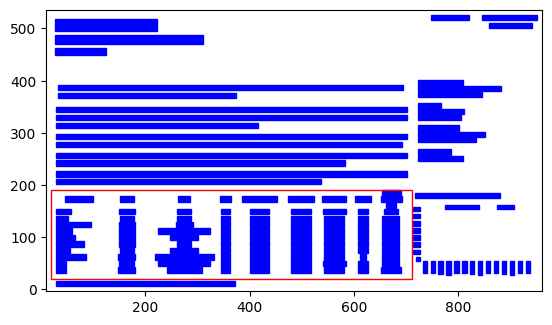

In [4]:
# Testing different values for table_areas
filepath = RAW_DATA_DIR / '2021-12.pdf'
table_areas = ['20,190,710,20']
tables = camelot.read_pdf(str(filepath), flavor='stream', edge_tol=500, table_areas = table_areas)
camelot.plot(tables[0], kind='contour')
plt.show()

In [5]:
print(tables[0].parsing_report)
print(tables[0].shape)
tables[0].df

{'accuracy': 100.0, 'whitespace': 13.68, 'order': 1, 'page': 1}
(13, 9)


,0,1,2,3,4,5,6,7,8
0,,,,,,,,,Valor de
1,Companhia,Ticker,Setor,Peso,Recomendação,Preço atual,Preço-alvo,Upside,mercado
2,,,,,,,,,(Mn)
3,Arezzo,ARZZ3,Varejo,10%,Compra,"R$ 68,20","R$ 108,00",58%,"R$ 6,8"
4,Assaí,ASAI3,Varejo,10%,Compra,"R$ 13,05","R$ 23,00",76%,"R$ 17,6"
5,Banco do Brasil,BBAS3,Bancos,10%,Compra,"R$ 30,81","R$ 52,00",69%,"R$ 87,9"
6,Gerdau,GGBR4,Mineração e Siderurgia,10%,Compra,"R$ 25,80","R$ 32,00",24%,"R$ 44,0"
7,Localiza,RENT3,Transportes,10%,Compra,"R$ 52,25","R$ 68,00",30%,"R$ 39,6"
8,RaiaDrogasil,RADL3,Varejo,10%,Compra,"R$ 22,61","R$ 27,00",19%,"R$ 37,4"
9,Rumo,RAIL3,Transportes,10%,Compra,"R$ 17,62","R$ 24,00",36%,"R$ 32,7"


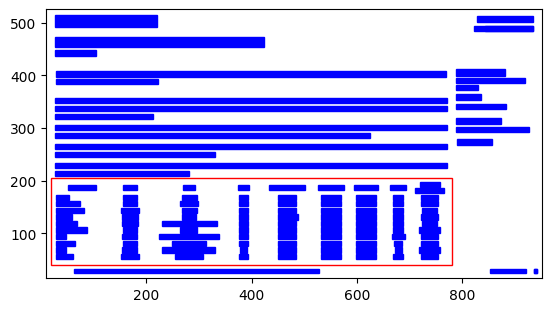

In [6]:
# Starting from Feb 2023 the table_areas need to be adjusted
filepath = RAW_DATA_DIR / '2023-02.pdf'
table_areas = ['20,205,780,40']
tables = camelot.read_pdf(str(filepath), flavor='stream', edge_tol=500, table_areas = table_areas)
camelot.plot(tables[0], kind='contour')
plt.show()

In [7]:
print(tables[0].parsing_report)
print(tables[0].shape)
tables[0].df

{'accuracy': 100.0, 'whitespace': 14.53, 'order': 1, 'page': 1}
(13, 9)


,0,1,2,3,4,5,6,7,8
0,,,,,,,,,Valor de
1,Companhia,Ticker,Setor,Peso,Recomendação,Preço atual,Preço-alvo,Upside,
2,,,,,,,,,mercado (Bi)
3,Assaí,ASAI3,Varejo,10%,Compra,"R$ 19,65","R$ 27,00",12%,"R$ 27,6"
4,Eletrobras,ELET3,Energia,10%,Compra,"R$ 40,65","R$ 71,00",75%,"R$ 96,5"
5,Grupo Soma,SOMA3,Varejo,10%,Compra,"R$ 10,50","R$ 14,00",81%,"R$ 7,5"
6,Hypera,HYPE3,Saúde,10%,Compra,"R$ 46,40","R$ 56,50",22%,"R$ 27,6"
7,Iguatemi,IGTI11,Imobiliário e Shoppings,10%,Compra,"R$ 19,59","R$ 28,00",43%,"R$ 5,6"
8,Itaú Unibanco,ITUB4,Bancos,15%,Compra,"R$ 25,33","R$ 34,00",34%,"R$ 252,0"
9,JBS,JBSS3,"Agro, Alimentos e Bebidas",10%,Compra,"R$ 20,08","R$ 58,10",189%,"R$ 48,7"


In [18]:
def extract_table(filepath: pathlib.Path, table_areas: list) -> pd.DataFrame:
    tables = camelot.read_pdf(str(filepath), flavor='stream', edge_tol=500, table_areas = table_areas)
    if len(tables) == 0:
        raise ValueError(f"No tables found in {filepath}")
    table = tables[0]
    accuracy = table.parsing_report['accuracy']
    if accuracy < 100:
        print(f"Accuracy of table extraction of {filepath} is {accuracy}%")
    
    df = table.df
    df = df.iloc[-10:]
    df.reset_index(drop=True, inplace=True)
    
    columns = ['company', 'ticker', 'industry', 'portfolio_weight', 'reccomendation', 'price', 'target', 'upside', 'market_cap']
    
    df.columns = columns
    df.set_index('ticker', inplace=True)
    
    if (df.shape[1] != 8):
        raise ValueError(f"Table in {filepath} has wrong number of columns ({df.shape[1]})")
    
    print(f"Extracted table from {filepath.stem}")

    return df

In [30]:
files = sorted(os.listdir(RAW_DATA_DIR))
data = dict()
for i in range(len(files)):
    if i < 15:
        table_areas = ['20,190,710,20']
    else:
        table_areas = ['20,205,780,40']
    try:
        filepath = RAW_DATA_DIR / files[i]
        df = extract_table(filepath, table_areas)
        data[filepath.stem] = df
    except Exception as e:
        print(f"ERROR ({files[i]}) | {e}")
        continue

Extracted table from 2021-12
Extracted table from 2022-01
Extracted table from 2022-02
Extracted table from 2022-03
Extracted table from 2022-04
Extracted table from 2022-05
Extracted table from 2022-06
Extracted table from 2022-07
Extracted table from 2022-08


/home/gabrielhso/Desktop/insper/2024.1/algotrading/portifolio-balancing/env/lib/python3.10/site-packages/camelot/parsers/stream.py:448: UserWarning: page-1 is image-based, camelot only works on text-based pages.
  warnings.warn(


ERROR (2022-09.pdf) | No tables found in /home/gabrielhso/Desktop/insper/2024.1/algotrading/portifolio-balancing/data/raw/2022-09.pdf
Extracted table from 2022-10
Extracted table from 2022-11
Extracted table from 2022-12
Extracted table from 2023-01
Accuracy of table extraction of /home/gabrielhso/Desktop/insper/2024.1/algotrading/portifolio-balancing/data/raw/2023-02.pdf is 99.06%
ERROR (2023-02.pdf) | Length mismatch: Expected axis has 8 elements, new values have 9 elements
Extracted table from 2023-03
Extracted table from 2023-04
Extracted table from 2023-05
Extracted table from 2023-06
Extracted table from 2023-07
Extracted table from 2023-08
Extracted table from 2023-09
Extracted table from 2023-10
Extracted table from 2023-11
Extracted table from 2023-12
Extracted table from 2024-01
Extracted table from 2024-02
Extracted table from 2024-03
Extracted table from 2024-04
Extracted table from 2024-05


In [31]:
# Table extraction for 2022-09 made by ChatGPT
table_data = {
    "Companhia": ["Assaí", "Banco do Brasil", "Grupo Soma", "Hypera", "Iguatemi", "Itaú Unibanco", "Petrobras", "Raízen", "Rumo", "Vale"],
    "Ticker": ["ASAI3", "BBAS3", "SOMA3", "HYPE3", "IGTI11", "ITUB4", "PETR4", "RAIZ4", "RAIL3", "VALE3"],
    "Setor": ["Varejo", "Bancos", "Varejo", "Saúde", "Imobiliário e Shoppings", "Bancos", "Petróleo e Gás", "Agro, Alimentos e Bebidas", "Transportes", "Mineração e Siderurgia"],
    "Peso": ["10%", "5%", "10%", "10%", "10%", "15%", "15%", "10%", "10%", "5%"],
    "Recomendação": ["Compra", "Compra", "Compra", "Compra", "Compra", "Compra", "Compra", "Compra", "Compra", "Compra"],
    "Preço atual": ["R$ 18,39", "R$ 41,69", "R$ 13,53", "R$ 43,07", "R$ 19,68", "R$ 25,81", "R$ 33,23", "R$ 4,84", "R$ 20,21", "R$ 64,50"],
    "Preço-alvo": ["R$ 22,00", "R$ 57,00", "R$ 19,00", "R$ 48,00", "R$ 28,00", "R$ 27,27", "R$ 47,30", "R$ 9,60", "R$ 24,00", "R$ 97,10"],
    "Upside": ["20%", "37%", "40%", "11%", "42%", "6%", "42%", "98%", "19%", "51%"],
    "Valor de mercado (Bi)": ["R$ 25,2", "R$ 121,7", "R$ 10,9", "R$ 27,7", "R$ 5,3", "R$ 236,0", "R$ 463,3", "R$ 51,9", "R$ 38,6", "R$ 302,6"]
}

df = pd.DataFrame(table_data)

display(df)

,Companhia,Ticker,Setor,Peso,Recomendação,Preço atual,Preço-alvo,Upside,Valor de mercado (Bi)
0,Assaí,ASAI3,Varejo,10%,Compra,"R$ 18,39","R$ 22,00",20%,"R$ 25,2"
1,Banco do Brasil,BBAS3,Bancos,5%,Compra,"R$ 41,69","R$ 57,00",37%,"R$ 121,7"
2,Grupo Soma,SOMA3,Varejo,10%,Compra,"R$ 13,53","R$ 19,00",40%,"R$ 10,9"
3,Hypera,HYPE3,Saúde,10%,Compra,"R$ 43,07","R$ 48,00",11%,"R$ 27,7"
4,Iguatemi,IGTI11,Imobiliário e Shoppings,10%,Compra,"R$ 19,68","R$ 28,00",42%,"R$ 5,3"
5,Itaú Unibanco,ITUB4,Bancos,15%,Compra,"R$ 25,81","R$ 27,27",6%,"R$ 236,0"
6,Petrobras,PETR4,Petróleo e Gás,15%,Compra,"R$ 33,23","R$ 47,30",42%,"R$ 463,3"
7,Raízen,RAIZ4,"Agro, Alimentos e Bebidas",10%,Compra,"R$ 4,84","R$ 9,60",98%,"R$ 51,9"
8,Rumo,RAIL3,Transportes,10%,Compra,"R$ 20,21","R$ 24,00",19%,"R$ 38,6"
9,Vale,VALE3,Mineração e Siderurgia,5%,Compra,"R$ 64,50","R$ 97,10",51%,"R$ 302,6"


In [32]:
columns = ['company', 'ticker', 'industry', 'portfolio_weight', 'reccomendation', 'price', 'target', 'upside', 'market_cap']

df.columns = columns
df.set_index('ticker', inplace=True)

data['2022-09'] = df

In [33]:
data['2022-09']

,company,industry,portfolio_weight,reccomendation,price,target,upside,market_cap
ticker,,,,,,,,
ASAI3,Assaí,Varejo,10%,Compra,"R$ 18,39","R$ 22,00",20%,"R$ 25,2"
BBAS3,Banco do Brasil,Bancos,5%,Compra,"R$ 41,69","R$ 57,00",37%,"R$ 121,7"
SOMA3,Grupo Soma,Varejo,10%,Compra,"R$ 13,53","R$ 19,00",40%,"R$ 10,9"
HYPE3,Hypera,Saúde,10%,Compra,"R$ 43,07","R$ 48,00",11%,"R$ 27,7"
IGTI11,Iguatemi,Imobiliário e Shoppings,10%,Compra,"R$ 19,68","R$ 28,00",42%,"R$ 5,3"
ITUB4,Itaú Unibanco,Bancos,15%,Compra,"R$ 25,81","R$ 27,27",6%,"R$ 236,0"
PETR4,Petrobras,Petróleo e Gás,15%,Compra,"R$ 33,23","R$ 47,30",42%,"R$ 463,3"
RAIZ4,Raízen,"Agro, Alimentos e Bebidas",10%,Compra,"R$ 4,84","R$ 9,60",98%,"R$ 51,9"
RAIL3,Rumo,Transportes,10%,Compra,"R$ 20,21","R$ 24,00",19%,"R$ 38,6"
